In [1]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [2]:
!pip list


Package                       Version
----------------------------- ---------------
absl-py                       2.0.0
aiobotocore                   2.5.0
aiofiles                      22.1.0
aiohttp                       3.8.5
aioitertools                  0.7.1
aiosignal                     1.2.0
aiosqlite                     0.18.0
alabaster                     0.7.12
altair                        5.1.2
anaconda-anon-usage           0.4.2
anaconda-catalogs             0.2.0
anaconda-client               1.12.1
anaconda-cloud-auth           0.1.3
anaconda-navigator            2.5.0
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
archspec                      0.2.1
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse                    1.6.3
async-time

In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [8]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [9]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# Data Loading Functions

In [17]:
import gdown

In [18]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=58eac425-070f-4d14-a4b0-47970f215622
To: C:\Users\pathi\OneDrive\Desktop\LipReader\data.zip
100%|████████████████████████████████████████████████████████████████████████████████| 423M/423M [24:13<00:00, 291kB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [19]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame) #grayscale has less info to process
        frames.append(frame[190:236,80:220,:]) #extracting only the lips from each frame statically , original implementation used dlib
    cap.release()
    
    #standardizing the data
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [21]:
# defining the vocubalary (All letters and digits)
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [23]:
# This function uses a function from keras ctc asr tutorial to convert characters to integers and vice versa , helpful in deoding
#output later. asr - automatic speech recognition 

char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size = {char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size = 40)


In [24]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [25]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11], dtype=int64)>

In [26]:
 num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [28]:
# pre process the alignments
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [29]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [30]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [31]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [32]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

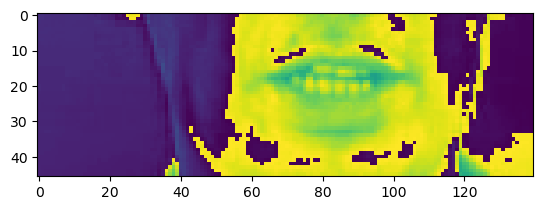

In [33]:
plt.imshow(frames[40])

In [34]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [35]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [36]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# Creating the Data Pipeline

In [37]:
from matplotlib import pyplot as plt

In [38]:
#creating a data pipeline 
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False) #shuffled batches of 500
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))  
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [39]:
len(test)

50

In [40]:
frames, alignments = data.as_numpy_iterator().next()

In [41]:
len(frames)

2

In [42]:
sample = data.as_numpy_iterator()

In [43]:
val = sample.next(); val[0]

array([[[[[1.3910496 ],
          [1.3910496 ],
          [1.3910496 ],
          ...,
          [9.660067  ],
          [9.660067  ],
          [9.041822  ]],

         [[1.3910496 ],
          [1.3910496 ],
          [1.3910496 ],
          ...,
          [9.119103  ],
          [9.235024  ],
          [9.003182  ]],

         [[1.2751288 ],
          [1.2751288 ],
          [1.2751288 ],
          ...,
          [9.3895855 ],
          [9.621427  ],
          [9.660067  ]],

         ...,

         [[0.8887262 ],
          [0.8887262 ],
          [0.8887262 ],
          ...,
          [9.775988  ],
          [9.737348  ],
          [9.698708  ]],

         [[0.8887262 ],
          [0.8887262 ],
          [0.8887262 ],
          ...,
          [9.621427  ],
          [9.698708  ],
          [9.660067  ]],

         [[0.8887262 ],
          [0.8887262 ],
          [0.8887262 ],
          ...,
          [9.660067  ],
          [9.698708  ],
          [9.621427  ]]],


        [[[1.2364

In [44]:
imageio.mimsave('./animation.gif', val[0][0], fps=10) #saved in folder

Lossy conversion from float32 to uint8. Range [0.0, 9.85326862335205]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.85326862335205]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.85326862335205]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.85326862335205]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.85326862335205]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.85326862335205]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.85326862335205]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0.0, 9.85326862335205]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.85326862335205]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.85326862335205]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.85326862335205]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.85326862335205]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.85326862335205]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.85326862335205]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

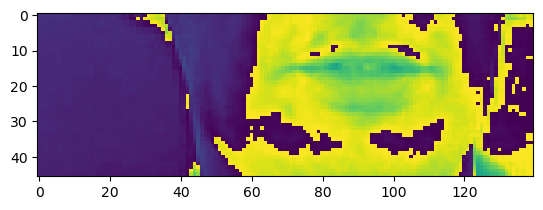

In [45]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][35])

In [46]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place white in j five again'>

# Design the neural network

In [68]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler


In [69]:
data.as_numpy_iterator().next()[0][0].shape #shape to be passed to conv3d

(75, 46, 140, 1)

In [70]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [71]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation_3 (Activation)   (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 75, 23, 70, 128)   0         
 g3D)                                                            
                                                                 
 conv3d_4 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_4 (Activation)   (None, 75, 23, 70, 256)   0         
                                                      

In [51]:
yhat = model.predict(val[0])  #checking prediction format (gibberish for now)

1/1 [==============================] - 14s 14s/step


In [52]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'hhrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr'>

In [53]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'hhrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr'>

In [56]:
tf.argmax(yhat[0],axis = 1)

<tf.Tensor: shape=(75,), dtype=int64, numpy=
array([ 8,  8, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18], dtype=int64)>

In [57]:
model.input_shape

(None, 75, 46, 140, 1)

In [58]:
model.output_shape

(None, 75, 41)

# Creating the training functions 

In [59]:
# scheduler for the number of epochs
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [60]:
# CTC Loss function - a special loss function (used in ASR tutorial)
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [61]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [72]:
adam = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss=CTCLoss)

checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

schedule_callback = LearningRateScheduler(scheduler)

example_callback = ProduceExample(test)

In [63]:
#fitting the model 
model.fit(train, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])


Epoch 1/100
 69/450 [===>..........................] - ETA: 6:29:30 - loss: 117.1354

KeyboardInterrupt: 

# Testing and Prediction

In [64]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=d18fff27-a318-4474-9d41-177f12986a7a
To: C:\Users\pathi\OneDrive\Desktop\LipReader\checkpoints.zip
100%|██████████████████████████████████████████████████████████████████████████████| 94.5M/94.5M [05:15<00:00, 300kB/s]


['models\\checkpoint.index',
 'models\\__MACOSX/._checkpoint.index',
 'models\\checkpoint.data-00000-of-00001',
 'models\\__MACOSX/._checkpoint.data-00000-of-00001',
 'models\\checkpoint',
 'models\\__MACOSX/._checkpoint']

In [73]:
model.load_weights('models/checkpoint')

In [74]:
test_data = test.as_numpy_iterator()

In [75]:
sample = test_data.next()

In [76]:
yhat = model.predict(sample[0])

1/1 [==============================] - 18s 18s/step


In [77]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay green at f six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set green at p three again'>]

In [78]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [79]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay green at f six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set green at p three again'>]

# Video Testing

In [80]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [81]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [82]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 5s 5s/step


In [83]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [84]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]